In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")
library(igraph)
library(pheatmap)
setwd("/projects/CARDIPS/analysis/epigenome_resource/")



Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

### Load all lead variants from iPSCORE and GTEx QTLs

In [3]:
leads = fread("analyses/jennifer/ipscore_unique_qtls/mashr/2024_0911/input/ipscore_gtex_leadvars_stats.txt",
                     sep="\t",
                     data.table = F)

In [297]:

messlength(unique(mashr$gene_id))
length(unique(mashr$variant_id))

nrow(mashr)

[1] 33793

[1] 250564

[1] 281938

In [4]:
mashr = fread("analyses/jennifer/ipscore_unique_qtls/mashr/2024_0911/results/mashr_results.txt",sep="\t",data.table=F)

mashr$gene_id = str_extract(mashr$gene_variant, "^ENSG[0-9]+") 
mashr$variant_id = str_extract(mashr$gene_variant, "VAR_[0-9]+_[0-9]+_[A-Z]_[A-Z]") 


mashr$min_ipscore_lfsr = rowMins(data.matrix(mashr[,6:8]))
mashr$min_adult_lfsr    = rowMins(data.matrix(mashr[,c(9:55)]))
mashr$min_lfsr         = rowMins(data.matrix(mashr[,c(6:55)]))

mashr2 = mashr[ mashr$min_lfsr < 0.05 & mashr$ngtex_tested > 0 & mashr$nipscore_tested > 0 , ]


In [402]:
nrow(mashr) 
nrow(mashr2)

[1] 281938

[1] 102375

In [5]:
mashr2$Category = ifelse(mashr2$min_adult_lfsr < 0.05 & mashr2$min_ipscore_lfsr < 0.05, "Shared",
                              ifelse(mashr2$min_adult_lfsr > 0.05 & mashr2$min_ipscore_lfsr < 0.05, "EDev",
                                    ifelse(mashr2$min_adult_lfsr < 0.05 & mashr2$min_ipscore_lfsr > 0.05,
                                           "Adult", "Not Significant")))

mashr2$variant_id = gsub("VAR_","",str_extract(mashr2$gene_variant, "VAR_.*"))
table(mashr2$Category)

kgenomes = fread("/projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/gwas_independent/reference/combined.renamed.bim",
                 sep="\t",
                data.table=F)

mashr2$in_kg = ifelse(mashr2$variant_id %in% kgenomes$V2, "TRUE","FALSE")
mashr3 = mashr2[ mashr2$in_kg == "TRUE",]


 Adult   EDev Shared 
 27881   2299  72195 

In [14]:
write_snps = lapply(unique(mashr3$gene_id), function(gene){
    genedf = mashr3[ mashr3$gene_id == gene,]
    snpid = gsub("VAR_","",genedf$variant_id)
    if(length(unique(snpid)) > 1) {
        writeLines(unique(snpid),
               paste0("analyses/tim/ld_modules/mashr_ld/snps/",gene,"_snps.txt"))
        }
})

### Run 03.8.calculate_egene_ld_mashr.sh to identify SNP-eGene pairs representing the same signal

In [6]:
ld.fs = list.files("analyses/tim/ld_modules/mashr_ld/ld", full.names = T, pattern =".ld")
length(ld.fs)

psize(10,10)
read_ld = rbindlist(lapply(ld.fs, function(ld.f){
    gene = gsub(".ld","",gsub("analyses/tim/ld_modules/mashr_ld/ld/","",ld.f))
    all.ld = fread(ld.f,sep=" ",data.table=F)[,c("SNP_A","SNP_B","R2")]
    all.ld$dist = abs(as.numeric(gsub("[0-9]+_","",str_extract(all.ld$SNP_A, "[0-9]+_[0-9]+")))-
                     as.numeric(gsub("[0-9]+_","",str_extract(all.ld$SNP_B, "[0-9]+_[0-9]+"))))

    if (nrow(all.ld) > 0 ){
    in.ld = all.ld[ all.ld$R2 >= 0.8 & all.ld$dist < 100000,]
    verts = data.frame(ids = unique(c(all.ld$SNP_A,all.ld$SNP_B)))
    g = graph_from_data_frame(in.ld, directed = FALSE, vertices = verts)
    cl = cluster_louvain(g)
    verts$gene_id = gene
    verts$cluster_id = paste(gene,cl$membership,sep="_")
    verts$variant_id = paste("VAR",verts$ids,sep="_")
    return(verts)}
}))

[1] 10343

### Add back SNPs that are the only lead variant for a given eGene

In [7]:

single_qtl = mashr3[ mashr3$gene_id %in% names(table(mashr3$gene_id))[ table(mashr3$gene_id) == 1],]
single_qtl$ids = gsub("VAR_","",single_qtl$variant_id)
single_qtl$cluster_id = paste(single_qtl$gene_id,1,sep="_")


[1] 630

In [8]:
mashr3$variant_id = str_extract(mashr3$gene_variant, "VAR_.*")

In [9]:
mashr4 = rbind(merge(mashr3,read_ld,by=c("gene_id","variant_id")),
                       single_qtl)


### Identify QTL clusters that have more than one Category and mark as Shared

In [12]:
cats = unique(mashr4[ ,c("Category","cluster_id")])
cats_dups = cats[ cats$cluster_id %in% names(table(cats$cluster_id))[ table(cats$cluster_id) > 1],]

In [13]:
mashr4$AdjCategory = ifelse(mashr4$cluster_id %in% cats_dups$cluster_id, "Shared",mashr4$Category)

In [14]:
mashr5 = unique(mashr4[,c("gene_id","ntissues_tested","ngtex_tested",
                                          "min_lfsr","min_adult_lfsr","min_ipscore_lfsr","gene_variant","cluster_id","AdjCategory")])



### Identify most significant SNPs in each QTL

In [15]:
mashr6 = mashr5 %>% group_by(cluster_id) %>% top_n(1,-log10(min_lfsr)) %>% top_n(1,ntissues_tested)

In [403]:
nrow(mashr6)

[1] 67269

### Select random SNP-eGene pair when there are equally significant pairs in a QTL signal

In [16]:
mashr7 = mashr6 %>% group_by(cluster_id) %>% sample_n(1)

In [17]:
nrow(mashr7)

[1] 57364

In [18]:
length(unique(mashr7$gene_id))
nrow(mashr7)
table(mashr7$AdjCategory)

[1] 10971

[1] 57364


 Adult   EDev Shared 
 20539   2207  34618 

In [19]:
lead_stats_ipsc_var = leads[leads$gene_variant %in% mashr7$gene_variant,]
lead_stats_cast = reshape2::dcast(gene_variant ~ tissue, data = lead_stats_ipsc_var, fun.aggregate = mean, value.var="beta")
rownames(lead_stats_cast) = lead_stats_cast$gene_variant
lead_stats_cast$gene_variant = NULL
lead_stats_mat = data.matrix(lead_stats_cast)

# Calculate row means considering NA values
row_means <- rowMeans(lead_stats_mat, na.rm = TRUE)

# Replace NA with row means
lead_stats_mat = t(apply(lead_stats_mat, 1, function(x) {
  x[is.na(x)] = row_means[which(is.na(x))] 
  return(x)
}))




In [224]:
length(unique(mashr7$gene_id[ mashr7$AdjCategory == "Adult"]))
length(unique(mashr7$gene_id[ mashr7$AdjCategory == "EDev"]))
length(unique(mashr7$gene_id[ mashr7$AdjCategory == "Shared"]))

[1] 7165

[1] 1919

[1] 9229

In [23]:
figure3a = as.data.frame(table(mashr7$AdjCategory))
figure3a$Specificity = factor(figure3a$Var1, levels = c("EDev","Adult","Shared"))
figure3a$No_eQTLs = figure3a$Freq
fwrite(figure3a[,3:4], "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3A.txt",
      sep="\t",row.names=F,quote=F)

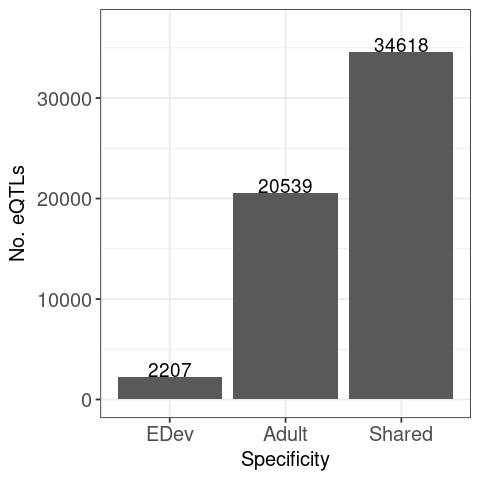

In [24]:

psize(4,4)


a = ggplot(figure3a, aes(Specificity, No_eQTLs)) + theme_bw2 + 
        xlab("Specificity") + ylab("No. eQTLs") +
        ylim(c(0,37000)) +
        geom_bar(stat = "identity") + 
        geom_text(aes(label = No_eQTLs), vjust = 0, size =4)
a

Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(edev_cor). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(shar_cor). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed

QTL Specificity,mean_r
<fct>,<dbl>
EDev,0.001188834
Adult,0.004061838
Shared,0.211740161


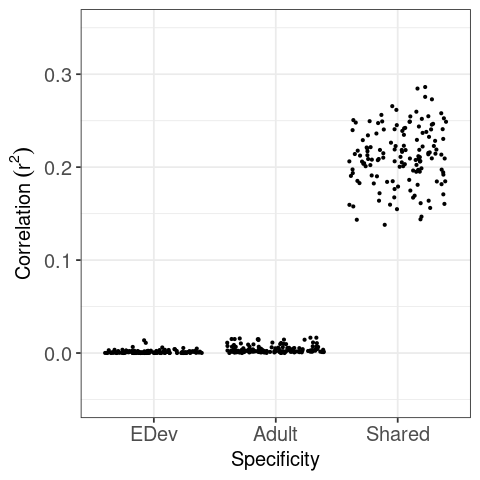

In [25]:
paletteLength <- 50
myColor <- colorRampPalette(c("blue", "white", "red"))(paletteLength)
# length(breaks) == length(paletteLength) + 1
# use floor and ceiling to deal with even/odd length pallettelengths
myBreaks <- c(seq(-0.5, 0, length.out=ceiling(paletteLength/2) + 1), 
              seq(1/paletteLength, 1, length.out=floor(paletteLength/2)))
edev_cor = cor(lead_stats_mat[ rownames(lead_stats_mat) %in% mashr7$gene_variant[ mashr7$AdjCategory == "EDev"],])

shar_cor = cor(lead_stats_mat[ rownames(lead_stats_mat) %in% mashr7$gene_variant[ mashr7$AdjCategory == "Shared"],])
adult_cor = cor(lead_stats_mat[ rownames(lead_stats_mat) %in% mashr7$gene_variant[ mashr7$AdjCategory == "Adult"],])


edev_melt = melt(edev_cor)
edev_melt$Type = "EDev"
shar_melt = melt(shar_cor)
shar_melt$Type = "Shared"
adult_melt = melt(adult_cor)
adult_melt$Type = "Adult"

melted = rbind(rbind(edev_melt,shar_melt),adult_melt) %>% filter(Var1 != Var2)
melted$Tissue1 = as.character(melted$Var1)
melted$Tissue2 = as.character(melted$Var2)
melted$r2 = melted$value**2
melted$Var1 = NULL
melted$Var2 = NULL
melted2 = melted[!duplicated(apply(melted,1,function(x) paste(sort(x),collapse=''))),]
melted3 = melted2[ melted2$Tissue1 %in% c("iPSC","CVPC","PPC") |  melted2$Tissue2 %in% c("iPSC","CVPC","PPC"),]
melted4 = melted3 [ !(melted3$Tissue1 == "iPSC" &  melted3$Tissue2 == "CVPC") &
                     !(melted3$Tissue1 == "PPC" &  melted3$Tissue2 == "iPSC") &
                     !(melted3$Tissue1 == "PPC" &  melted3$Tissue2 == "CVPC"),]
melted4$`iPSCORE Tissue` = ifelse(melted4$Tissue1 %in% c("iPSC","CVPC","PPC"), melted4$Tissue1,
                                  ifelse(melted4$Tissue2 %in% c("iPSC","CVPC","PPC"), melted4$Tissue2, NA))
melted4$`iPSCORE Tissue` = factor(melted4$`iPSCORE Tissue`, levels = c("iPSC","CVPC","PPC"))
melted4$`QTL Specificity` = factor(melted4$Type, levels = c("EDev","Adult","Shared"))
melted4 %>% group_by(`QTL Specificity`) %>% summarise(mean_r = mean(r2))



In [26]:
fwrite(melted4, 
      "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3B.txt",sep="\t",row.names=F,quote=F)

In [27]:
melted4 %>% group_by(`QTL Specificity`) %>% summarise(mean_r = mean(value))
t.test(melted4$r2[ melted4$`QTL Specificity` == "EDev"],
      melted4$r2[ melted4$`QTL Specificity` == "Adult"])$p.value

t.test(melted4$r2[ melted4$`QTL Specificity` == "EDev"],
      melted4$r2[ melted4$`QTL Specificity` == "Shared"])$p.value

t.test(melted4$r2[ melted4$`QTL Specificity` == "Adult"],
      melted4$r2[ melted4$`QTL Specificity` == "Shared"])$p.value

QTL Specificity,mean_r
<fct>,<dbl>
EDev,0.02003603
Adult,-0.05646204
Shared,0.45889373


[1] 1.497787e-12

[1] 1.12378e-119

[1] 7.57729e-121

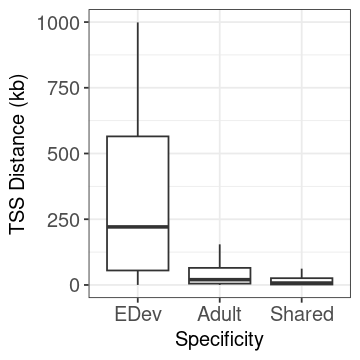

In [28]:
gene_info = fread("/reference/private/Gencode.v44lift38/gene_info.txt",sep="\t",data.table=F)
gene_info$simple_gene = gsub(".[0-9]+$","",gene_info$gene_id)
mashr7$pos = as.numeric(gsub("_[A-Z]+","",str_extract(mashr7$gene_variant, "[0-9]+_[A-Z]+")))
gene_info_key = gene_info[,c("start","end","strand","simple_gene")] %>% rename(gene_id = simple_gene)
gene_info_key$tss = ifelse(gene_info_key$strand == "+",gene_info_key$start,gene_info_key$end)
mashr8 = merge(mashr7,gene_info_key[,c("gene_id","tss")])
mashr8$dist = abs(mashr8$tss - mashr8$pos)

mashr9 = aggregate(dist ~   gene_id + AdjCategory, data = mashr8 , FUN = min)
psize(3,3)
mashr9$Category = factor(mashr9$AdjCategory, levels = c("EDev","Adult","Shared"))
c = ggplot(mashr9, aes(Category, dist/1000, group=Category)) + theme_bw2 + 
        xlab("Specificity") + ylab("TSS Distance (kb)") + geom_boxplot(outlier.shape = NA)
c

In [30]:
fwrite(mashr9,"~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3C.txt",sep="\t",row.names=F,quote=F)

In [231]:
wilcox.test(mashr9$dist[ mashr9$AdjCategory == "EDev"],
           mashr9$dist[ mashr9$AdjCategory == "Adult"])$p.value

wilcox.test(mashr9$dist[ mashr9$AdjCategory == "EDev"],
           mashr9$dist[ mashr9$AdjCategory == "Shared"])$p.value

wilcox.test(mashr9$dist[ mashr9$AdjCategory == "Adult"],
           mashr9$dist[ mashr9$AdjCategory == "Shared"])$p.value

wilcox.test(mashr9$dist[ mashr9$AdjCategory == "Shared"],
           mashr9$dist[ mashr9$AdjCategory != "Shared"])$p.value

[1] 0

[1] 0

[1] 1.905084e-212

[1] 0

In [232]:
median(mashr9$dist[ mashr9$Category == "EDev"])/1000
median(mashr9$dist[ mashr9$Category == "Adult"])/1000
median(mashr9$dist[ mashr9$Category == "Shared"])/1000

[1] 220.765

[1] 20.125

[1] 7.257

In [305]:
head(mashr2)

,gene_variant,ntissues_tested,ntissues_significant,nipscore_tested,ngtex_tested,iPSC,CVPC,PPC,Adipose_Subcutaneous,Adipose_Visceral_Omentum,⋯,Uterus,Vagina,Whole_Blood,gene_id,variant_id,min_ipscore_lfsr,min_adult_lfsr,min_lfsr,Category,in_kg
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
26,ENSG00000000460 VAR_1_169689048_G_A,49,35,2,47,0.4329926477,0.2051221,0.38257843,1.108653e-02,6.031723e-05,⋯,0.0009129624,0.0052146534,1.382889e-01,ENSG00000000460,1_169689048_G_A,0.2051220785,6.106227e-15,6.106227e-15,Adult,TRUE
27,ENSG00000000460 VAR_1_169732760_T_C,49,32,2,47,0.0005621301,0.3426939,0.02676851,1.508706e-02,1.792079e-01,⋯,0.3663687523,0.0463298483,1.178893e-06,ENSG00000000460,1_169732760_T_C,0.0005621301,3.148968e-13,3.148968e-13,Shared,TRUE
28,ENSG00000000460 VAR_1_169787407_G_C,49,41,2,47,0.0608333680,0.1030256,0.02584250,1.287603e-06,7.766831e-09,⋯,0.0018617972,0.0020140470,4.555623e-06,ENSG00000000460,1_169787407_G_C,0.0258425014,1.110223e-16,1.110223e-16,Shared,TRUE
29,ENSG00000000460 VAR_1_169788227_C_T,49,33,2,47,0.1573223014,0.2259091,0.41322111,2.711182e-03,1.431340e-07,⋯,0.0031434072,0.0088126748,1.142856e-01,ENSG00000000460,1_169788227_C_T,0.1573223014,0.000000e+00,0.000000e+00,Adult,TRUE
30,ENSG00000000460 VAR_1_169789148_T_G,49,44,2,47,0.0151797162,0.1160146,0.28955346,4.792290e-06,4.435268e-10,⋯,0.0005139700,0.0002915120,7.116609e-07,ENSG00000000460,1_169789148_T_G,0.0151797162,0.000000e+00,0.000000e+00,Shared,TRUE
31,ENSG00000000460 VAR_1_169795911_C_G,49,44,2,47,0.0125097221,0.1027032,0.09678492,9.401548e-06,6.215445e-09,⋯,0.0005765339,0.0000680898,5.701274e-06,ENSG00000000460,1_169795911_C_G,0.0125097221,1.110223e-16,1.110223e-16,Shared,TRUE


## Annotate eQTLs

[1] 19305

                
                 CVPC iPSC  PPC
  EDev            900 1068  248
  No Association 1116 3042 2076
  Shared         2821 4902 3132

Warning message:
“Removed 35 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


[1] 2.252503e-06

[1] 7.904659e-71

[1] 1.449785e-15

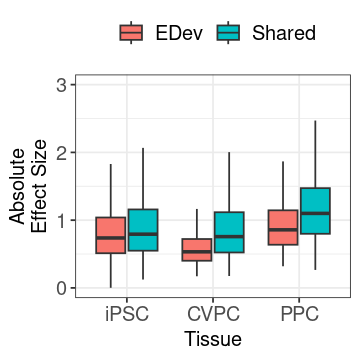

In [31]:
filtered_qtls = fread("analyses/tim/gwas_coloc/scripts/qtls_090424.txt",sep="\t",data.table=F)
eqtls = filtered_qtls[ filtered_qtls$type == 0 & grepl("^E",filtered_qtls$element_id),]

eqtls$gene_id = gsub(".[0-9]+$","",eqtls$element_id)
eqtls$variant_id = eqtls$id
eqtls$gene_variant = paste(eqtls$gene_id, eqtls$variant_id)


eqtls$Category = ifelse(eqtls$gene_variant %in% mashr5$gene_variant[ mashr5$AdjCategory == "EDev"], "EDev",
                       ifelse(eqtls$gene_variant %in% mashr5$gene_variant[ mashr5$AdjCategory == "Shared"], "Shared","No Association"))

table(eqtls$Category, eqtls$tissue)    
eqtls$tissue = factor(eqtls$tissue, levels = c("iPSC","CVPC","PPC"))
psize(3,3)
e = ggplot(eqtls[ eqtls$Category %in% c("EDev","Shared"),], aes(tissue, abs(beta), fill = Category)) + theme_bw2 + 
            theme(legend.title = element_text(size = 0)) + 
            ylab("Absolute\nEffect Size") + xlab("Tissue") +
            ylim(c(0,3)) +
            geom_boxplot(outlier.shape =  NA)
e
wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "iPSC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "iPSC"]))$p.value
wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "CVPC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "CVPC"]))$p.value
wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "PPC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "PPC"]))$p.value

In [35]:
fwrite(eqtls[eqtls$Category %in% c("EDev","Shared"),c("element_id","tissue","beta","Category")],
       "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3E.txt",
       sep="\t",row.names=F,quote=F)

In [37]:
length(unique(eqtls$gene_variant[ eqtls$Category == "EDev"]))
length(unique(eqtls$gene_variant[ eqtls$Category == "No Association"]))



[1] 2180

[1] 6073

In [40]:
table(eqtls$Category)
# table(eqtls$tissue,eqtls$Category)



          EDev No Association         Shared 
          2216           6234          10855 

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'tissue', 'Category'. You can override
using the `.groups` argument.


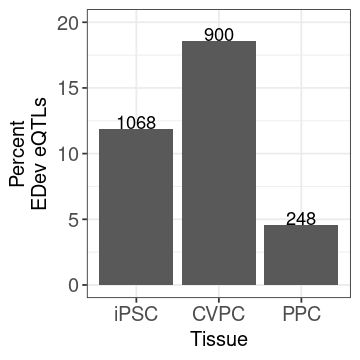

In [41]:

eqtl_summary = eqtls %>% group_by(tissue) %>% mutate(n_eQTLs = n()) %>% ungroup()

edev_summary = unique(eqtl_summary %>% group_by(tissue, Category) %>% 
                                summarize(n_edev = n(), frac_eqtls = (n()/n_eQTLs)*100)) %>% filter(Category == "EDev")

edev_summary$Tissue = factor(edev_summary$tissue, levels= c("iPSC","CVPC","PPC"))
fwrite(edev_summary,"~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3D.txt",
       sep="\t",row.names=F,quote=F)
d = ggplot(edev_summary, aes(Tissue, frac_eqtls)) + theme_bw2 + 
        ylim(0,20) + ylab("Percent\nEDev eQTLs") +
        geom_text(aes(label = n_edev), vjust = 0) + 
        geom_bar(stat="identity")
d
# table(eqtl_modules$Category, eqtl_modules$Tissue)

In [235]:
manifest = fread("analyses/jennifer/gwas_independent/subset_manifest.txt", data.table = F)
gwas_summary = fread("analyses/tim/gwas_coloc2/scripts/gwas_summary.txt",sep="\t",data.table=F)
manifest$trait_id = NULL
names(manifest)[4] = "trait_id"
head(manifest)
gwas_summary2 = merge(gwas_summary, manifest[,c("trait_id","description")])

coloced = gwas_summary2[ gwas_summary2$PP.H4.abf >=0.8 & gwas_summary2$topsnp_pp >= 0.01 &
             gwas_summary2$p.gwas < 5e-8 & gwas_summary2$p.eqtl < 5e-5, ]

,trait_type,coding_description,description,trait_id,filename,exists
,<chr>,<lgl>,<chr>,<chr>,<chr>,<lgl>
1,continuous,NA,Healthspan,healthspan_summary,/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/gwas_liftover/hg38_summary_statistics/healthspan_summary.hg38.tsv.gz,TRUE
2,continuous,NA,Longevity,lifegen_phase2_bothpl_alldr_2017_09_18,/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/gwas_liftover/hg38_summary_statistics/lifegen_phase2_bothpl_alldr_2017_09_18.hg38.tsv.gz,TRUE
3,continuous,NA,Multivariate Longevity,timmers2020_healthspan_lifespan_longevity,/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/gwas_liftover/hg38_summary_statistics/timmers2020_healthspan_lifespan_longevity.hg38.tsv.gz,TRUE
4,continuous,NA,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,/projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/gwas_liftover/hg38_summary_statistics/biomarkers-30760-both_sexes-irnt.meta.hg38.tsv.gz,TRUE
5,continuous,NA,LDL direct,biomarkers-30780-both_sexes-irnt.meta,/projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/gwas_liftover/hg38_summary_statistics/biomarkers-30780-both_sexes-irnt.meta.hg38.tsv.gz,TRUE
6,continuous,NA,birth weight (eur),BW3_EUR_summary_stats,/projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/gwas_liftover/hg38_summary_statistics/BW3_EUR_summary_stats.hg38.tsv.gz,TRUE


In [279]:
edev_eqtls = eqtls [ eqtls$Category == "EDev", ]

plot_eqtls = rbindlist(lapply(edev_eqtls$path, function(x){
    tissue = ifelse(grepl("iPSC",x),"iPSC",ifelse(grepl("CVPC",x),"CVPC","PPC"))
    if (grepl("step_4",x)) {
        df = fread(x,sep="\t") %>% filter(type == 0 ) %>% select(pos, pval, element_id)
        df$tissue = tissue
    } else {
         df = fread(x,sep="\t")  %>% select(pos, pval, element_id)
         df$tissue = tissue
    }
    return(df)
}))

In [283]:
plot_eqtls$tissue_element = paste(plot_eqtls$tissue,plot_eqtls$element_id,sep="_")
psize(20,20)
# ggplot(plot_eqtls, aes(pos, -log10(pval))) + geom_point() + facet_wrap(~tissue_element, nrow = 10, scales = "free")

In [286]:
edev_eqtls = eqtls [ eqtls$Category == "EDev", ]
psize(3,3)
summary(-log10(edev_eqtls$pval))


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.542   5.722   6.931   9.487  10.428  68.911 

In [108]:
$coloc = ifelse(eqtl_modules$tissue_element %in% gwas_coloc$tissue_element, "TRUE", "FALSE")
eqtl_modules2 = eqtl_modules[ eqtl_modules$Category != "No Association", ]
table(eqtl_modules2$coloc,eqtl_modules2$Category)

fisher.test(matrix(c(21,1254,236,11014),nrow=2))

       
         EDev Shared
  FALSE  1254  11014
  TRUE     21    236


	Fisher's Exact Test for Count Data

data:  matrix(c(21, 1254, 236, 11014), nrow = 2)
p-value = 0.3472
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4730414 1.2283564
sample estimates:
odds ratio 
 0.7815742 


In [380]:
# # eqtls = fread("~/projects/Resource/RevisionTables/TableS6_eQTLs.txt",sep="\t",data.table=F) %>% filter(Significant == "TRUE" & DPrime == "FALSE")
# eqtls = filtered_qtls[ filtered_qtls$type == 0 & grepl("^E",filtered_qtls$element_id),]
# nrow(eqtls)
# # eqtls$element_cond = paste(eqtls$Tissue, eqtls$`Element ID`, eqtls$Condition,sep="_")
# eqtls$gene_id = gsub(".[0-9]+$","",eqtls$element_id)
# eqtls$variant_id = eqtls$id
# eqtls$gene_variant = paste(eqtls$gene_id, eqtls$variant_id)


# eqtls$Category = ifelse(eqtls$gene_variant %in% mashr_eqtls$gene_variant[ mashr_eqtls$Category == "EDev"], "EDev",
#                        ifelse(eqtls$gene_variant %in% mashr_eqtls$gene_variant[ mashr_eqtls$Category == "Shared"], "Shared","No Association"))

# table(eqtls$Category)    
# eqtls$tissue = factor(eqtls$tissue, levels = c("iPSC","CVPC","PPC"))
# psize(3,3)
# e = ggplot(eqtls[ eqtls$Category %in% c("EDev","Shared"),], aes(tissue, abs(beta), fill = Category)) + theme_bw2 + 
#             theme(legend.title = element_text(size = 0)) + 
#             ylab("Absolute\nEffect Size") + xlab("Tissue") +
#             ylim(c(0,3)) +
#             geom_boxplot(outlier.shape =  NA)
# e
# wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "iPSC"]),
#                abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "iPSC"]))$p.value
# wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "CVPC"]),
#                abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "CVPC"]))$p.value
# wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "PPC"]),
#                abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "PPC"]))$p.value

Warning message:
“Removed 24 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


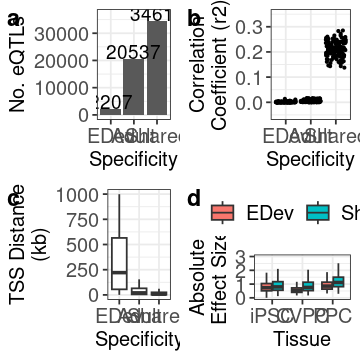

In [287]:
# psize(5,5.2)
plot_grid(a,b,c,d,labels=c("a","b","c","d"))
# dev.off()

In [383]:
psize(6.5,5.2)
png("~/projects/Resource/notebooks/toGitHub/figures/edev_figure_0919.png",units="in",res=300,height=6.5,width=5.2)
plot_grid(a,b,c,d,e,labels=c("a","b","c","d","e"),nrow=3)
dev.off()

Warning message:
“Removed 35 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


png 
  2

In [115]:
# coloced %>% filter(tissue %in% c("PPC","CVPC")) %>% select(tissue,gene_name,element_id,description,topsnp)


In [237]:
edev_gwas = coloced %>% filter(tissue_element %in% eqtls$tissue_element[ eqtls$Category == "EDev"] & tissue %in% c("CVPC","PPC"))

edev_gwas2 = merge(edev_gwas,gene_info[,5:6],by.x="element_id",by.y="gene_id")

In [271]:
edev_gwas2

element_id,trait_id,analysis,tissue,qtl_id,type,nsnps,PP.H0.abf,PP.H1.abf,PP.H2.abf,⋯,se.eqtl,p.eqtl,beta.gwas,se.gwas,p.gwas,bonferroni.eqtl,cs_size,tissue_element,description,gene_name
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
ENSG00000076351.13,biomarkers-30780-both_sexes-irnt.meta,eqtls,CVPC,0-ENSG00000076351.13,0,2380,1.098441e-06,4.799006e-06,2.437152e-02,⋯,0.10600973,4.804834e-06,0.01595,0.002354,1.230269e-11,1.146914e-02,14,CVPC_ENSG00000076351.13,LDL direct,SLC46A1
ENSG00000102879.17,biomarkers-30760-both_sexes-irnt.meta,eqtls,PPC,0-ENSG00000102879.17,0,1412,9.950164e-08,9.967158e-07,8.470019e-03,⋯,0.12177106,3.161727e-09,-0.01651,0.002494,3.548134e-11,4.477006e-06,40,PPC_ENSG00000102879.17,HDL cholesterol,CORO1A
ENSG00000103415.12,continuous-23104-both_sexes-irnt.meta,eqtls,PPC,0-ENSG00000103415.12,0,4561,7.975057e-28,4.837618e-28,1.084015e-01,⋯,0.09044642,4.510849e-06,0.03123,0.002582,1.122018e-33,2.061458e-02,2,PPC_ENSG00000103415.12,Body mass index (BMI),HMOX2
ENSG00000132199.20,biomarkers-30760-both_sexes-irnt.meta,eqtls,CVPC,0-ENSG00000132199.20,0,4263,7.579437e-11,1.983029e-08,6.178551e-04,⋯,0.08133039,5.729582e-11,0.03550,0.004858,2.691535e-13,2.462574e-07,1,CVPC_ENSG00000132199.20,HDL cholesterol,ENOSF1
ENSG00000141338.15,biomarkers-30760-both_sexes-irnt.meta,eqtls,CVPC,0-ENSG00000141338.15,0,4016,3.584478e-21,8.425667e-20,2.048892e-03,⋯,0.09165078,1.089305e-09,-0.02699,0.002665,4.168694e-24,4.392077e-06,18,CVPC_ENSG00000141338.15,HDL cholesterol,ABCA8
ENSG00000164880.16,continuous-23104-both_sexes-irnt.meta,eqtls,PPC,0-ENSG00000164880.16,0,4976,3.276440e-12,6.017101e-09,9.410799e-05,⋯,0.19711849,1.944632e-15,-0.02265,0.002986,3.311311e-14,9.717328e-12,10,PPC_ENSG00000164880.16,Body mass index (BMI),INTS1
ENSG00000170365.10,biomarkers-30760-both_sexes-irnt.meta,eqtls,CVPC,0-ENSG00000170365.10,0,2887,1.640253e-06,2.472827e-05,8.295825e-03,⋯,0.08655746,3.389068e-07,0.02278,0.003556,1.496236e-10,9.811350e-04,6,CVPC_ENSG00000170365.10,HDL cholesterol,SMAD1
ENSG00000179604.10,continuous-23104-both_sexes-irnt.meta,eqtls,CVPC,0-ENSG00000179604.10,0,4932,6.716753e-06,5.083972e-05,4.735871e-03,⋯,0.07392330,3.259927e-08,0.01502,0.002527,2.786121e-09,1.620510e-04,24,CVPC_ENSG00000179604.10,Body mass index (BMI),CDC42EP4
ENSG00000198523.6,continuous-12340-both_sexes-irnt.meta,eqtls,CVPC,0-ENSG00000198523.6,0,3718,6.539408e-16,7.013196e-15,1.341253e-02,⋯,0.06058947,5.418567e-07,0.06707,0.007277,3.090295e-20,2.018416e-03,4,CVPC_ENSG00000198523.6,QRS duration,PLN


In [264]:
edev_gwas2 %>% filter(gene_name == "CORO1A") %>% select(topsnp,topsnp_pp,element_id,tissue)
eqtls %>% filter(tissue == "PPC" & element_id == "ENSG00000102879.17")

topsnp,topsnp_pp,element_id,tissue
<chr>,<dbl>,<chr>,<chr>
VAR_16_29956694_C_T,0.07752088,ENSG00000102879.17,PPC


element_id,type,new_egene,chrom,pos,ref,alt,id,rsid,beta,⋯,data_type,path,taskid,path_exists,egene,analysis,gene_id,variant_id,gene_variant,Category
<chr>,<int>,<lgl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<int>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000102879.17,0,TRUE,chr16,29967506,G,A,VAR_16_29967506_G_A,rs4788203,-0.6235031,⋯,eqtls,/projects/CARDIPS/analysis/epigenome_resource/eqtls/PPC/step_5/qtl_by_element/qtl/qtl.ENSG00000102879.17.txt,45147,TRUE,TRUE,eqtls,ENSG00000102879,VAR_16_29967506_G_A,ENSG00000102879 VAR_16_29967506_G_A,EDev


In [265]:
gtex.fs = paste0("analyses/jennifer/gtex_egene_comparison/gtex_eqtls/",unique(leads$tissue),"/qtl.ENSG00000102879.txt")

cols = colnames(fread(gtex.fs[1],sep="\t",data.table=F))
read_gtex_qtls = rbindlist(lapply(gtex.fs, function(f) {
    if (file.exists(f)) {
        tissue = gsub("/.*","",gsub("analyses/jennifer/gtex_egene_comparison/gtex_eqtls/","",f))
        qtldf = fread(f, sep="\t",data.table=F, fill=TRUE)
        qtldf2 = qtldf[ , colnames(qtldf) %in% cols, ]
        qtldf2$tissue = tissue
        qtldf2$pos = as.numeric(gsub("chr16_","",str_extract(qtldf2$variant_id,"chr16_[0-9]+")))
        qtldf2$topsnp = ifelse(qtldf2$pos == 29967506, "TRUE","FALSE")
        return(qtldf2[ order(qtldf2$topsnp),])
        }
    
    }
), use.names=TRUE)


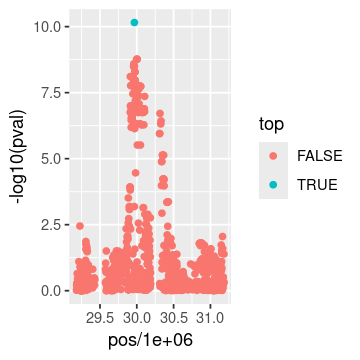

In [267]:

psize(3,3)
tmp = fread("/projects/CARDIPS/analysis/epigenome_resource/eqtls/PPC/step_5/qtl_by_element/qtl/qtl.ENSG00000102879.17.txt",sep="\t",data.table=F)
tmp$top = ifelse(tmp$id == "VAR_16_29967506_G_A", "TRUE","FALSE")
tmp2 = tmp[ order(tmp$top), ] 
ggplot(tmp2, aes(pos/1000000, -log10(pval), color = top) )+ geom_point()


In [130]:
mashr2 [ mashr2$variant_id %like% "VAR_4_145482013",]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


gene_variant,ntissues_tested,ntissues_significant,nipscore_tested,ngtex_tested,iPSC,CVPC,PPC,Adipose_Subcutaneous,Adipose_Visceral_Omentum,⋯,Uterus,Vagina,Whole_Blood,gene_id,variant_id,min_ipscore_lfsr,min_adult_lfsr,min_lfsr,Category,in_kg
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>


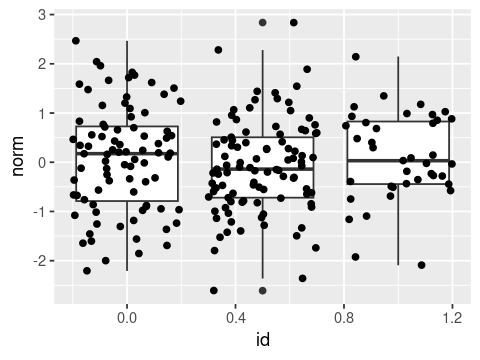

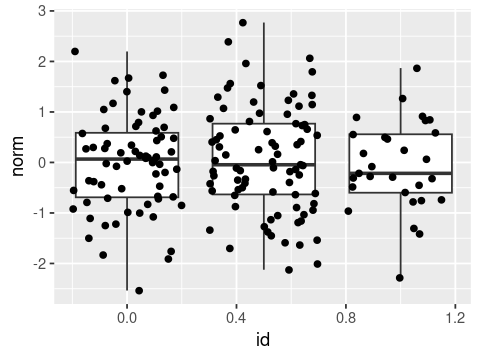

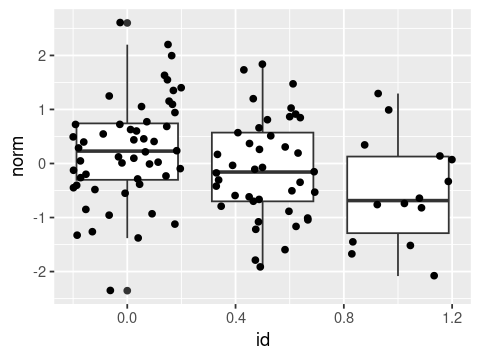

In [268]:


plot_qtl = function(gene_id, variant_id, tissue) {
    meta  = fread(paste0("eqtls/",tissue,"/step_1/metadata.txt"),sep="\t",data.table=F)[,c("phenotype_id","genotype_id")]
    geno  = as.data.frame(t(add_rownames(fread(paste0("eqtls/",tissue,"/step_1/genotype/by_element/gt_data.",gene_id,".txt"),sep="\t",data.table=F) %>% 
                    filter(V1 == variant_id))))
    geno$genotype_id = rownames(geno)
    geno2            = merge(meta,geno)
    names(geno2)[3] = "id"
    pheno = merge(fread(paste0("eqtls/",tissue,"/step_1/phenotype/by_element/",gene_id,".txt"),sep="\t",data.table=F) %>% 
                rename(phenotype_id = sample_id),geno2)

    p = ggplot(pheno, aes(id, norm, group = as.character(id))) + geom_boxplot() + geom_jitter()
    return(p)
    }
psize(3,4)
plot_qtl("ENSG00000102879.17","VAR_16_29967506_G_A","iPSC")
plot_qtl("ENSG00000102879.17","VAR_16_29967506_G_A","CVPC")
plot_qtl("ENSG00000102879.17","VAR_16_29967506_G_A","PPC")


# ggplot(ipsc_enos,aes(pos,-log10(pval))) + geom_point()
# ggplot(cvpc_enos,aes(pos,-log10(pval))) + geom_point()
# ggplot(ppc_enos,aes(pos,-log10(pval))) + geom_point()

In [175]:
ld = fread("analyses/tim/ld_modules/mashr_ld/ld/ENSG00000170365.ld",sep=" ",data.table=F)

In [176]:
ld

CHR_A,BP_A,SNP_A,CHR_B,BP_B,SNP_B,R2
<int>,<int>,<chr>,<int>,<int>,<chr>,<dbl>
4,145466082,4_145466082_T_C,4,145495253,4_145495253_G_A,0.19373100
4,145466082,4_145466082_T_C,4,145568826,4_145568826_A_G,0.12246400
4,145466082,4_145466082_T_C,4,145710189,4_145710189_C_T,0.03184020
4,145495253,4_145495253_G_A,4,145568826,4_145568826_A_G,0.68137800
4,145495253,4_145495253_G_A,4,145710189,4_145710189_C_T,0.00910765
4,145568826,4_145568826_A_G,4,145710189,4_145710189_C_T,0.00885086


In [401]:
231/nrow(eqtls[ eqtls$Category == "Shared",])
25/nrow(eqtls[ eqtls$Category == "EDev",])

# eqtls [ eqtls$tissue_element %in% coloced$tissue_element & eqtls$Category == "Shared",]
# coloced [ coloced$tissue_element %in% eqtls$tissue_element[ eqtls$Category == "EDev"],]
fisher.test(matrix(c(25,2216,231,10855),nrow=2))

[1] 0.02128052

[1] 0.01128159


	Fisher's Exact Test for Count Data

data:  matrix(c(25, 2216, 231, 10855), nrow = 2)
p-value = 0.001707
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3352251 0.8050531
sample estimates:
odds ratio 
 0.5301623 


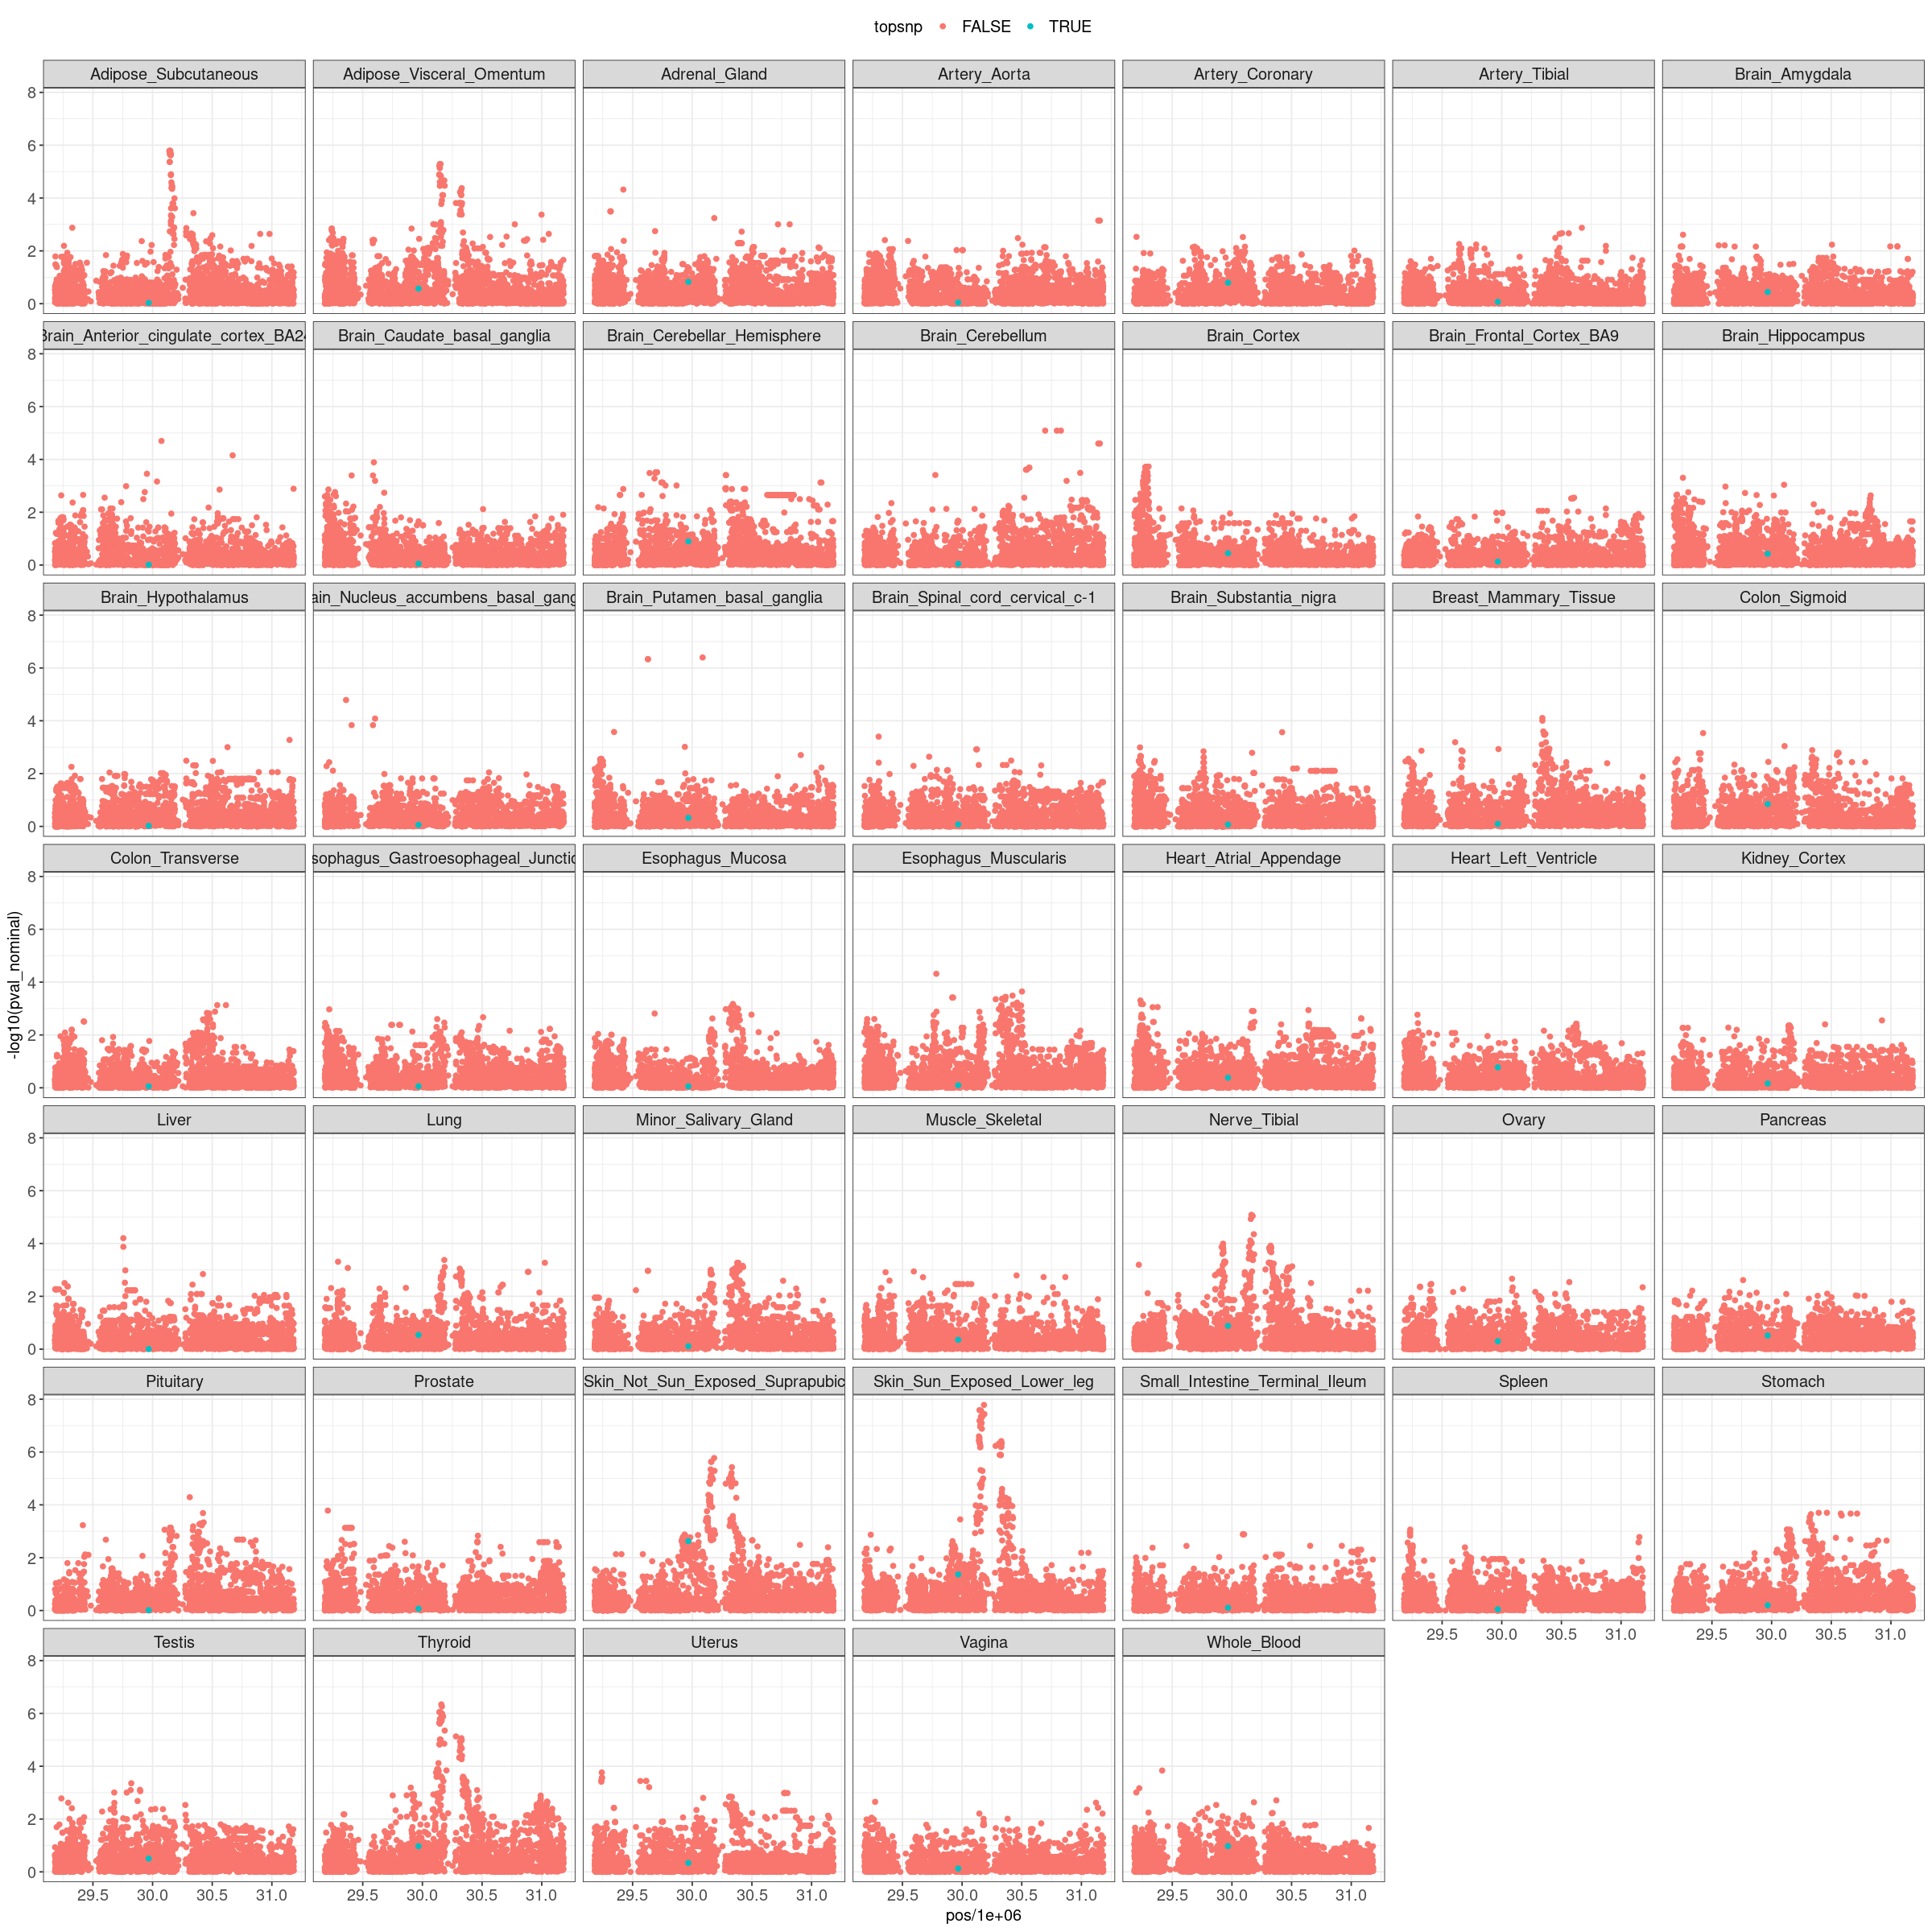

In [269]:
psize(20,20)
ggplot(read_gtex_qtls, aes(pos/1000000,-log10(pval_nominal), color=topsnp)) + theme_bw2 + 
    geom_point() +
    facet_wrap(~tissue)
        
# VAR_6_118381458_C_T

### Shared QTLs are in promoters
### GWAS loci dont overlap promoters, small effect sizes
### Specific QTLs are in enhancers
### Why dont EDev specific QTLs overlap GWAS more than the shared?
##### EDev unique are under higher evolutionary constraint, but may not contribute to adult traits/diseases.

##### Closest GWAS loci to the adult and EDev specific and shared QTLs. 
##### Measure LD of these variants ^ and GWAS loci - are GWAS loci more associated with shared, adult/fetal specific?

In [1109]:

conkey = merge(gene_info[,c("simple_gene","gene_name")],constraint, by.x="gene_name",by.y="gene")
tmp = merge(conkey,mashr_results7[,c("gene_id","Bucket")],by.x="simple_gene",by.y="gene_id")

tmp$pli = ifelse(tmp$lof_hc_lc.pLI > 0.8, "TRUE","FALSE")
nrow(unique(tmp))

table(tmp$pli,tmp$Bucket)
table(tmp$Bucket)

fisher.test(matrix(c(36,73,275+1420,620+6431),nrow=2))
fisher.test(matrix(c(36,73,1420,6431),nrow=2))
fisher.test(matrix(c(36,73,275,620),nrow=2))


fisher.test(matrix(c(849,3138,87,772),nrow=2))
# fisher.test(matrix(c(849,3138,314,1872),nrow=2))$p.value
# 314/(314+1872)

[1] 8855

       
        Adult EDev Shared
  FALSE   620   73   6431
  TRUE    275   36   1420


 Adult   EDev Shared 
   895    109   7851 


	Fisher's Exact Test for Count Data

data:  matrix(c(36, 73, 275 + 1420, 620 + 6431), nrow = 2)
p-value = 0.0008894
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.331487 3.110192
sample estimates:
odds ratio 
  2.051307 



	Fisher's Exact Test for Count Data

data:  matrix(c(36, 73, 1420, 6431), nrow = 2)
p-value = 0.0002333
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.448654 3.388381
sample estimates:
odds ratio 
  2.233146 



	Fisher's Exact Test for Count Data

data:  matrix(c(36, 73, 275, 620), nrow = 2)
p-value = 0.661
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.705901 1.725963
sample estimates:
odds ratio 
  1.111706 



	Fisher's Exact Test for Count Data

data:  matrix(c(849, 3138, 87, 772), nrow = 2)
p-value = 2.26e-15
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.894666 3.070678
sample estimates:
odds ratio 
  2.400422 


In [394]:
mashr_results6 = mashr_results3[ mashr_results3$Bucket != "Not Significant" &
                                !mashr_results3$gene_id %in% mashr_results4$gene_id[ mashr_results4$MultiQTL == "TRUE"],]
mashr_results6$meanlogP = rowMeans(data.matrix(mashr_results6[,6:55]))
length(unique(mashr_results6$gene_id))
head(mashr_results6)

[1] 4360

,gene_variant,ntissues_tested,ntissues_significant,nipscore_tested,ngtex_tested,iPSC,CVPC,PPC,Adipose_Subcutaneous,Adipose_Visceral_Omentum,⋯,Vagina,Whole_Blood,gene_id,variant_id,inboth,minAllPval,meanlogP,minGTExlfsr,miniPSClfsr,Bucket
,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
47,ENSG00000000938 VAR_1_27564022_A_G,48,33,1,47,0.02465391,0.04711590,0.07105552,9.906676e-04,0.003315580,⋯,0.04946381,0.1741031736,ENSG00000000938,VAR_1_27564022_A_G,TRUE,4.375292e-04,0.04273425,4.375292e-04,0.02465391,Shared
48,ENSG00000000938 VAR_1_27634281_G_A,48,41,1,47,0.02017574,0.04426483,0.08130382,7.370836e-07,0.001034138,⋯,0.03580907,0.3053696831,ENSG00000000938,VAR_1_27634281_G_A,TRUE,1.327535e-14,0.03814819,1.327535e-14,0.02017574,Shared
49,ENSG00000000938 VAR_1_27634321_C_G,48,38,1,47,0.02442474,0.05101095,0.08250830,2.121053e-07,0.005972805,⋯,0.03582952,0.3980530540,ENSG00000000938,VAR_1_27634321_C_G,TRUE,7.192445e-12,0.04160630,7.192445e-12,0.02442474,Shared
227,ENSG00000001630 VAR_7_92013890_C_A,48,1,1,47,0.29089883,0.39757583,0.43654381,5.372539e-01,0.167390357,⋯,0.53519217,0.1357564321,ENSG00000001630,VAR_7_92013890_C_A,TRUE,4.440892e-16,0.28797863,4.440892e-16,0.29089883,Adult
229,ENSG00000001630 VAR_7_92169602_G_T,48,1,1,47,0.97141462,0.97754654,0.97893708,9.815043e-01,0.968140823,⋯,0.98075169,0.9669922167,ENSG00000001630,VAR_7_92169602_G_T,TRUE,2.220446e-16,0.95343284,2.220446e-16,0.97141462,Adult
277,ENSG00000002549 VAR_4_17541177_C_T,49,30,2,47,0.12067622,0.20930518,0.01764908,1.129550e-01,0.018593772,⋯,0.07430727,0.0002136743,ENSG00000002549,VAR_4_17541177_C_T,TRUE,2.136743e-04,0.05611964,2.136743e-04,0.01764908,Shared


In [751]:
table(mashr_results6$Bucket)/table(mashr_results5$Bucket)


   Adult     EDev   Shared 
4.102913 1.058824 9.709177 

In [447]:
library(multcomp)
library(broom)
library(dunn.test)


In [746]:
table(mashr_results7$Bucket)


 Adult   EDev Shared 
  4226    180  30681 

In [747]:
mashr_results7 = mashr_results6[ ,c("gene_id","variant_id","minAllPval","Bucket")]
mashr_results8 = mashr_results7 %>% group_by(gene_id) %>% top_n(1,-log10(minAllPval))
mashr_results7$chr = paste0("chr",gsub("_.*","",str_extract(mashr_results7$variant_id, "[0-9]+_[0-9]+")))
mashr_results7$pos = as.numeric(gsub(".*_","",str_extract(mashr_results7$variant_id, "[0-9]+_[0-9]+")))

mashr_results9 = merge(mashr_results7,gene_info[,c("simple_gene","start","end","strand")],
                       by.x="gene_id",by.y="simple_gene")
mashr_results9$dist = ifelse(mashr_results9$strand == "+",
                            abs(mashr_results9$pos - mashr_results9$start),
                            abs(mashr_results9$pos - mashr_results9$end))

length(unique(mashr_results9$gene_id))
# mashr_results10 = rbindlist(lapply(unique(mashr_results9$gene_id), function(gene) {
#     out = mashr_results9[ mashr_results9$gene_id == gene, ][1,]
#     return(out)
# }))

dput(head(mashr_results9))

# t.test(mashr_results9$dist[ mashr_results9$Bucket == "EDev"],
#             mashr_results9$dist[ mashr_results9$Bucket == "Shared"])
# t.test(mashr_results9$dist[ mashr_results9$Bucket == "Adult"],
#             mashr_results9$dist[ mashr_results9$Bucket == "Shared"])



[1] 4360

structure(list(gene_id = c("ENSG00000000938", "ENSG00000000938", 
"ENSG00000000938", "ENSG00000001630", "ENSG00000001630", "ENSG00000002549"
), variant_id = c("VAR_1_27564022_A_G", "VAR_1_27634281_G_A", 
"VAR_1_27634321_C_G", "VAR_7_92013890_C_A", "VAR_7_92169602_G_T", 
"VAR_4_17541177_C_T"), minAllPval = c(0.000437529151583373, 1.32753475191845e-14, 
7.19244483904191e-12, 4.44089209850063e-16, 2.22044604925031e-16, 
0.000213674251226775), Bucket = c("Shared", "Shared", "Shared", 
"Adult", "Adult", "Shared"), chr = c("chr1", "chr1", "chr1", 
"chr7", "chr7", "chr4"), pos = c(27564022, 27634281, 27634321, 
92013890, 92169602, 17541177), start = c(27612064L, 27612064L, 
27612064L, 92084987L, 92084987L, 17577198L), end = c(27635185L, 
27635185L, 27635185L, 92134803L, 92134803L, 17607972L), strand = c("-", 
"-", "-", "-", "-", "+"), dist = c(71163, 904, 864, 120913, 34799, 
36021)), row.names = c(NA, 6L), class = "data.frame")


In [560]:
# mashr_results9

In [462]:
?kruskal.test

kruskal.test {stats},R Documentation
x,"a numeric vector of data values, or a list of numeric data vectors. Non-numeric elements of a list will be coerced, with a warning."
g,a vector or factor object giving the group for the corresponding elements of x. Ignored with a warning if x is a list.
formula,a formula of the form response ~ group where response gives the data values and group a vector or factor of the corresponding groups.
data,an optional matrix or data frame (or similar: see model.frame) containing the variables in the formula formula. By default the variables are taken from environment(formula).
subset,an optional vector specifying a subset of observations to be used.
na.action,"a function which indicates what should happen when the data contain NAs. Defaults to getOption(""na.action"")."
...,further arguments to be passed to or from methods.
statistic,the Kruskal-Wallis rank sum statistic.
parameter,the degrees of freedom of the approximate chi-squared distribution of the test statistic.
p.value,the p-value of the test.


In [ ]:
fwrite(compare_out,"analyses/tim/edev_characterization/boot10.txt",sep="\t",row.names=F,quote=F)

In [569]:
# fwrite(mashr_results10,"analyses/tim/edev_characterization/mashr_filtered.txt",sep="\t",row.names=F,quote=F)
catch = list()
for ( i in 1:1000) {
      totest <- bind_rows(
      sample_n(mashr_results9 %>% filter(Bucket == "EDev"), 100, replace = FALSE),
      sample_n(mashr_results9 %>% filter(Bucket == "Adult"), 100, replace = FALSE),
      sample_n(mashr_results9 %>% filter(Bucket == "Shared"), 100, replace = FALSE)
    )
    pairwise_results <- dunn.test(totest$dist, totest$Bucket, method="bonferroni")
    out = data.frame(Comparison = pairwise_results$comparisons, iteration = i,
                    ChiSquared  = pairwise_results$chi2,
                    Zscore  = pairwise_results$Z,
                    Pvalue      = pairwise_results$P,
                    Adjusted    = pairwise_results$P.adjusted)
   catch[[i]] =  out

}


compare_out = rbindlist(catch)
fwrite(compare_out,"analyses/tim/edev_characterization/boot10.txt",sep="\t",row.names=F,quote=F)

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 45.8989, df = 2, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Adult       EDev
---------+----------------------
    EDev |  -4.379742
         |    0.0000*
         |
  Shared |   2.286465   6.666207
         |     0.0333    0.0000*

alpha = 0.05
Reject Ho if p <= alpha/2
  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 61.5773, df = 2, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      Adult       EDev
---------+----------------------
    EDev |  -5.119889
         |    0.0000*
         |
  Shared |   2.590104   7.709994
         |    0.0144*    0.0000*

alpha = 0.05
Reject Ho 

In [557]:
# compare_out

In [512]:
# fwrite(compare_out,"analyses/tim/edev_characterization/boot10.txt",sep="\t",row.names=F,quote=F)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


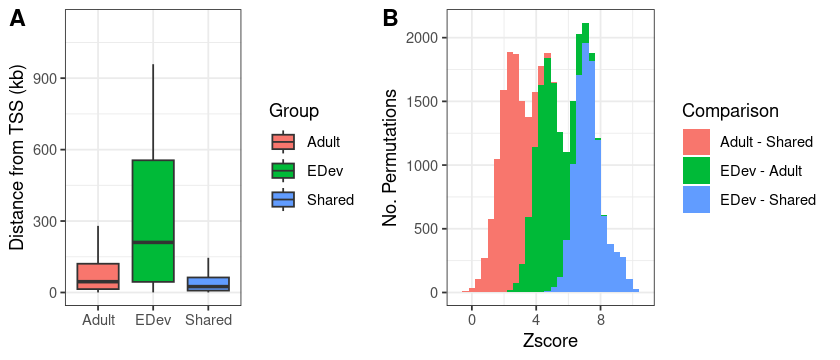

In [582]:
fs = list.files("analyses/tim/edev_characterization", full.names = T, pattern="boot")
perms = rbindlist(lapply(fs, function(x){
    df = fread(x,sep="\t")
    return(df)
}))
# perms
psize(4,6)
perms$Zscore = ifelse(perms$Comparison == "Adult - EDev", -perms$Zscore, perms$Zscore)
perms$Comparison = ifelse(perms$Comparison == "Adult - EDev", "EDev - Adult", perms$Comparison)

a = ggplot(perms,aes( -log10(Pvalue), fill=Comparison)) + theme_bw() + 
    ylab("No. Permutations") + geom_histogram()
a = ggplot(perms,aes( Zscore, fill=Comparison)) + theme_bw() + 
    ylab("No. Permutations") + geom_histogram()
b = ggplot(mashr_results9,aes( Bucket, dist/1000, fill=Bucket)) + theme_bw() + 
        xlab("") + ylab("Distance from TSS (kb)") + geom_boxplot(outlier.shape = NA) + 
        guides(fill=guide_legend(title="Group"))
psize(3,7)
plot_grid(b,a,nrow=1, rel_widths = c(0.8,1), labels = "AUTO")

In [754]:
perms %>% group_by(Comparison) %>% summarise(max(Pvalue))
perms %>% group_by(Comparison) %>% summarise(min(Pvalue))

Comparison,max(Pvalue)
<chr>,<dbl>
Adult - Shared,4.986992e-01
EDev - Adult,2.251216e-02
EDev - Shared,8.056306e-06


Comparison,min(Pvalue)
<chr>,<dbl>
Adult - Shared,2.286797e-08
EDev - Adult,9.468470e-17
EDev - Shared,3.230318e-26


In [585]:
ipsc_clusters = fread("analyses/tim/ld_modules/modules/ipsc_modules_100kb.postregression.txt",sep="\t",data.table=F)
ipsc_clusters$EDev = ifelse(ipsc_clusters$element_id %in% edev$`Element ID`[ edev$Category == "EDev" & edev$Tissue == "iPSC"],"EDev",
                           ifelse(ipsc_clusters$element_id %in% edev$`Element ID`[ edev$Category == "Shared" & edev$Tissue == "iPSC"]  ,"Shared",NA))


# cvpc_clusters = fread("analyses/tim/ld_modules/modules/cvpc_modules_100kb.postregression.txt",sep="\t",data.table=F)
# ppc_clusters = fread("analyses/tim/ld_modules/modules/ppc_modules_100kb.postregression.txt",sep="\t",data.table=F)

ERROR: Error in parse(text = x, srcfile = src): <text>:88:1: unexpected symbol
87: 
88: plot_manhattan
    ^
